### If players played 90 mins in all matches

$$
y \sim \textrm{Multinomial}(p_g,  p_a, p_0)
$$

where $p_g, p_a, p_0$ are the probabilities a player scores or assists a given goal (or does neither). $y$ is whether a player scored (1, 0, 0), assisted (0, 1, 0) or did neither (0, 0, 1) for a goal their team scores.

**Prior:**

$$
(p_g,  p_a, p_0) \sim \textrm{Dirichlet}(\alpha_g, \alpha_a, \alpha_0)
$$

where $\alpha_g, \alpha_a, \alpha_0$ are the priors for goals, assists and neither. The expected values are $\mathrm{E}[p_g] = \alpha_g / (\alpha_g + \alpha_a + \alpha_0)$ and so on, and the variance scales with the the $\alpha$ values (e.g. $\textrm{Dirichlet}(1, 1, 1)$ has higher variance than $\textrm{Dirichlet}(2, 2, 2)$).

**Posterior:**

As Dirichlet is a conjugate prior for the multinomial distribution, the posterior is also Dirichlet (see e.g. BDA3 Section 3.4 page 69, and [here](https://stephentu.github.io/writeups/dirichlet-conjugate-prior.pdf)):

$$
(p_g,  p_a, p_0) \sim \textrm{Dirichlet}(\alpha_g +n_g, \alpha_a + n_a, \alpha_0 + n_0)
$$

where $n_g, n_a, n_0$ are the total number of goals a player has scored or assisted, and the number of goals their team scored but they weren't involved in.



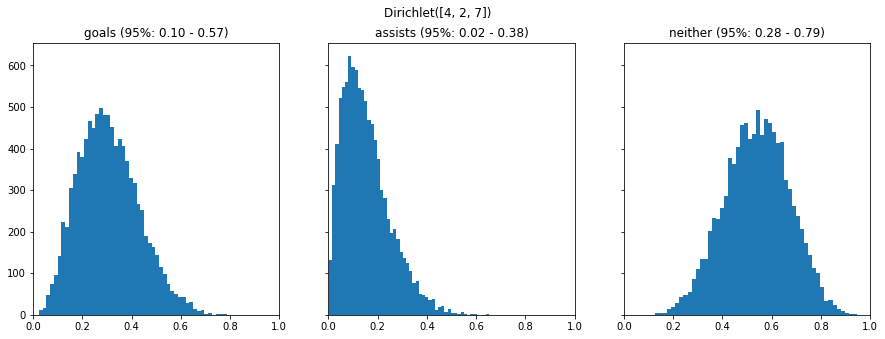

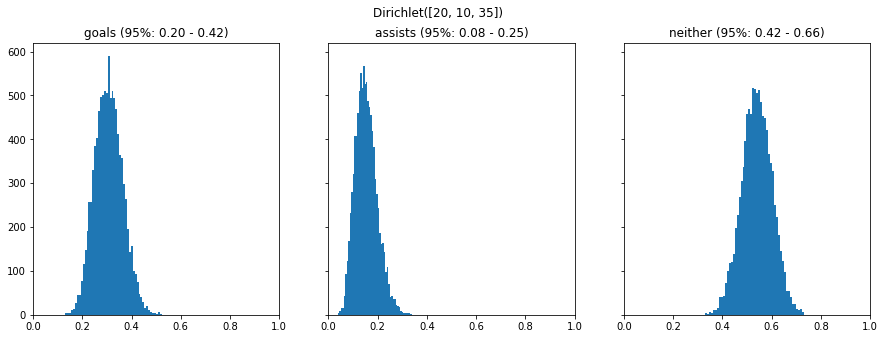

In [1]:
# Example Dirichlet distributions imagining a prior of 4 goals, 2 assists, 7 neither;  then a
# posterior with a player continuing at the same ratios to give 20 goals, 10 assists, 35  neither total.

from scipy.stats import dirichlet
import matplotlib.pyplot as plt
import numpy as np

def plot_dirichlet(a, n=10000, bins=50):
    dist = dirichlet(a)
    sample = dist.rvs(n)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    fig.suptitle(f"Dirichlet({a})")

    for i, name in enumerate(("goals", "assists", "neither")):
        ax[i].hist(sample[:, i], bins=bins)
        ax[i].set_title(
            f"{name} (95%: "
            f"{np.quantile(sample[:, i], 0.025):.2f} - "
            f"{np.quantile(sample[:, i], 0.975):.2f})"
        )
        ax[i].set_xlim((0, 1))

plot_dirichlet([4, 2, 7])
plot_dirichlet([20, 10, 35])

### Choice of $\alpha$ (Prior) and taking into account minutes - Previous Implementation

Previous AIrsenal prior (from `get_empirical_bayes_estimate`):
$$
\alpha_g = M \frac{N_g}{T_g} \frac{T_{mins}}{P_{mins}} \\
\alpha_a = M \frac{N_a}{T_g} \frac{T_{mins}}{P_{mins}} \\
\alpha_0 = M \left(\frac{N_0}{T_g} - \frac{T_{mins} - P_{mins}}{T_{mins}}\right) \frac{T_{mins}}{P_{mins}}
$$

where $M$ is the average number of matches played by players in a certain position (FWD/MID/DEF), $T_g$ is the total number of goals scored by the player's teams, $P_{mins}$ is the total number of minutes played by the players, and $T_{mins}$ is the total number of minutes played by the teams (90 * no. of matches), and the player and team stats are sums across all players in that position ($N_g$ rather than $n_g$ to indicate multiple players).

In words, $\alpha_g$ is: (no. matches played) * (fraction of goals scored) / (fraction of minutes played) across players in this position. So, effectively, estimated fraction of goals scored if players played full 90 mins in all matches, multiplied by no. matches.

- Fraction goals if playing full 90 mins is what we want to estimate (i.e. this is the $p_g$ term in $\theta$)
   - But I think it's more natural to use numbers of goals in the prior and posterior updating (as in sections above)

- Multiplication by no. of matches define strength of prior
   - But is using avg. no. matches a sensible choice? Is it too strong? Maybe something like having the prior equivalent to around 10 matches of data would make more sense?

When fitting the model the minutes are taken into account by scaling the goal probabilities:

$$
p_g = p_g \frac{m}{90} \\
p_a = p_a \frac{m}{90} \\
p_0 = p_0 \frac{m}{90} + \frac{90 - m}{90}
$$

where the $p_g, p_a, p_0$ values on the right are the original sampled probabilities sampled from the Dirichlet distribution and $m$ is the no. minutes played  by the player.

### Choice of $\alpha$ (Prior) and taking into account minutes - New Thoughts

For each player include only matches where:
- Player played at least 1 minute
   - player shouldn't be penalised for not being involved in goals when they weren't on the pitch
- Player's team scored at least 1 goal
   - matches without goals give no data on the probability of a player being involved in a goal their team scores

Limitation: We only know how many minutes a player played, how many goals they scored/assisted in the match, and how many goals their team scored/assisted in the match. We don't know _when_ goals were scored within the match, and critically we don't know how many goals the team scored when the player was on the pitch (if player played less than 90 mins). There's likely a data source where we could get this though (time goals scored and time subs came on/off)

To try to take this into account we can scale down the number of goals a player wasn't involved in by the fraction of the minutes they played:

$$
n_g = n_g \\
n_a = n_a \\
n_0 = T_g \frac{P_{mins}}{T_{mins}} - n_g - n_a
$$

where $T_g$ is the total number of goals scored by the player's team, $P_{mins}$ is the total number of minutes played by the player, and $T_{mins}$ is the total number of minutes played by the team (90 * no. of matches meeting the criteria above).

It's possible for $n_0$ to be negative (also true for $\alpha_0$ in the old implementation) for players that were involved in an unusually large number of goals for the number of minutes they played. These should be set to zero?

**Prior**
- Use $N_g$, $N_a$, $N_0$ as defined above but summed across all players in the position ($N_g = \sum n_g$ etc.)
- Pick a number of goals equivalent for the prior to sum to: $G = \alpha_g + \alpha_a + \alpha_0$
   - Suggest 13 goals, which is roughly average no. of goals scored by teams in 10 matches (2020/21 season).
   - Idea being that after 10 matches we should have a pretty good idea of their goal threat.

$$
\alpha_g = \frac{G N_g}{N_g + N_a + N_0} \\
\alpha_a = \frac{G N_a}{N_g + N_a + N_0} \\
\alpha_0 = \frac{G N_0}{N_g + N_a + N_0}
$$

Note these have units of goals (which is not the case for our original prior).

**Posterior**
-  As in the conjugate model:

$$
(p_g,  p_a, p_0) \sim \textrm{Dirichlet}(\alpha_g +n_g, \alpha_a + n_a, \alpha_0 + n_0)
$$

Don't need to sample to get the means, can compute them directly e.g.:
$$
\textrm{E}[p_g] = \frac{\alpha_g +n_g}{\alpha_g +n_g + \alpha_a + n_a + \alpha_0 + n_0}
$$

### Implementation

In [35]:
from airsenal.framework.prediction_utils import process_player_data
from airsenal.framework.player_model import scale_goals_by_minutes
from airsenal.framework.utils import get_player
from airsenal.framework.player_model import ConjugatePlayerModel
import pandas as pd


def fit_model(pos, n_goals_prior=13):
    data = process_player_data(pos)
    model = ConjugatePlayerModel().fit(data, n_goals_prior=n_goals_prior)
    return model

def display_model(model, n_display=10):
    df = pd.DataFrame(model.get_probs())
    df["player_name"] = df["player_id"].apply(lambda x: get_player(x).name)
    for c in ("prob_score", "prob_assist", "prob_neither"):
        sort_ascending = True if c == "prob_neither" else False
        display(df.sort_values(by=c, ascending=sort_ascending).head(n_display))
    return df

model_fwd = fit_model("FWD")
model_def = fit_model("DEF")
model_mid = fit_model("MID")

Filling history dataframe for Harry Kane: 0/75 done
Filling history dataframe for Romelu Lukaku: 1/75 done
Filling history dataframe for Jamie Vardy: 2/75 done
Filling history dataframe for Pierre-Emerick Aubameyang: 3/75 done
Filling history dataframe for Roberto Firmino: 4/75 done
Filling history dataframe for Timo Werner: 5/75 done
Filling history dataframe for Gabriel Fernando de Jesus: 6/75 done
Filling history dataframe for Edinson Cavani: 7/75 done
Filling history dataframe for Alexandre Lacazette: 8/75 done
Filling history dataframe for Danny Ings: 9/75 done
Filling history dataframe for Dominic Calvert-Lewin: 10/75 done
Filling history dataframe for Patrick Bamford: 11/75 done
Filling history dataframe for Anthony Martial: 12/75 done
Filling history dataframe for Richarlison de Andrade: 13/75 done
Filling history dataframe for Michail Antonio: 14/75 done
Filling history dataframe for Ollie Watkins: 15/75 done
Filling history dataframe for Callum Wilson: 16/75 done
Filling hist

Filling history dataframe for Konstantinos Mavropanos: 74/190 done
Filling history dataframe for William Saliba: 75/190 done
Filling history dataframe for Ben White: 76/190 done
Filling history dataframe for Nuno Varela Tavares: 77/190 done
Filling history dataframe for Björn Engels: 78/190 done
Filling history dataframe for Kortney Hause: 79/190 done
Filling history dataframe for Frédéric Guilbert: 80/190 done
Filling history dataframe for Axel Tuanzebe: 81/190 done
Filling history dataframe for Pontus Jansson: 82/190 done
Filling history dataframe for Rico Henry: 83/190 done
Filling history dataframe for Mads Roerslev Rasmussen: 84/190 done
Filling history dataframe for Mads Bech Sørensen: 85/190 done
Filling history dataframe for Ethan Pinnock: 86/190 done
Filling history dataframe for Kristoffer Ajer: 87/190 done
Filling history dataframe for Dominic Thompson: 88/190 done
Filling history dataframe for Dan Burn: 89/190 done
Filling history dataframe for Adam Webster: 90/190 done
Fil

Filling history dataframe for Enock Mwepu: 46/235 done
Filling history dataframe for Dwight McNeil: 47/235 done
Filling history dataframe for Jorge Luiz Frello Filho: 48/235 done
Filling history dataframe for Eberechi Eze: 49/235 done
Filling history dataframe for Alex Iwobi: 50/235 done
Filling history dataframe for Ayoze Pérez: 51/235 done
Filling history dataframe for Jack Harrison: 52/235 done
Filling history dataframe for Xherdan Shaqiri: 53/235 done
Filling history dataframe for Alex Oxlade-Chamberlain: 54/235 done
Filling history dataframe for Daniel James: 55/235 done
Filling history dataframe for Joseph Willock: 56/235 done
Filling history dataframe for Theo Walcott: 57/235 done
Filling history dataframe for Nathan Redmond: 58/235 done
Filling history dataframe for Stuart Armstrong: 59/235 done
Filling history dataframe for Erik Lamela: 60/235 done
Filling history dataframe for Steven Bergwijn: 61/235 done
Filling history dataframe for Giovani Lo Celso: 62/235 done
Filling his

Alpha is [ 7.54817451  7.47175218 54.43733826]


In [36]:
df_fwd = display_model(model_fwd);

,player_id,prob_score,prob_assist,prob_neither,player_name
7,56,0.414222,0.097801,0.487977,Danny Ings
42,362,0.383731,0.125098,0.491171,Teemu Pukki
17,123,0.368955,0.081688,0.549356,Chris Wood
14,111,0.368278,0.085614,0.546108,Florin Andone
0,4,0.365843,0.106465,0.527692,Pierre-Emerick Aubameyang
51,415,0.350319,0.135095,0.514586,Harry Kane
28,214,0.349878,0.160214,0.489908,Jamie Vardy
26,198,0.335624,0.116604,0.547772,Dominic Calvert-Lewin
73,1188,0.334005,0.127461,0.538534,Adam Armstrong
62,473,0.334005,0.127461,0.538534,Juan Camilo Hernández Suárez


,player_id,prob_score,prob_assist,prob_neither,player_name
21,150,0.149484,0.212954,0.637562,Timo Werner
6,51,0.253950,0.205528,0.540522,Keinan Davis
38,339,0.304386,0.202927,0.492686,Callum Wilson
40,350,0.149440,0.197447,0.653114,Allan Saint-Maximin
47,398,0.236179,0.195226,0.568596,Che Adams
1,6,0.319510,0.191536,0.488954,Alexandre Lacazette
63,482,0.277645,0.188117,0.534238,Michail Antonio
29,222,0.316536,0.186691,0.496773,Kelechi Iheanacho
32,241,0.300073,0.185542,0.514385,Patrick Bamford
59,468,0.308312,0.183591,0.508097,Emmanuel Dennis


,player_id,prob_score,prob_assist,prob_neither,player_name
7,56,0.414222,0.097801,0.487977,Danny Ings
1,6,0.319510,0.191536,0.488954,Alexandre Lacazette
28,214,0.349878,0.160214,0.489908,Jamie Vardy
42,362,0.383731,0.125098,0.491171,Teemu Pukki
38,339,0.304386,0.202927,0.492686,Callum Wilson
29,222,0.316536,0.186691,0.496773,Kelechi Iheanacho
64,502,0.324376,0.170336,0.505288,Raúl Jiménez
59,468,0.308312,0.183591,0.508097,Emmanuel Dennis
32,241,0.300073,0.185542,0.514385,Patrick Bamford
51,415,0.350319,0.135095,0.514586,Harry Kane


In [37]:
df_mid = display_model(model_mid);

,player_id,prob_score,prob_assist,prob_neither,player_name
115,267,0.280115,0.134471,0.585414,Mohamed Salah
137,315,0.273502,0.210435,0.516062,Bruno Miguel Borges Fernandes
178,417,0.266715,0.210036,0.523249,Heung-Min Son
118,274,0.263382,0.119158,0.617460,Diogo Jota
113,264,0.240932,0.116767,0.642300,Sadio Mané
19,44,0.237898,0.098818,0.663284,Anwar El Ghazi
142,326,0.236987,0.053756,0.709258,Mason Greenwood
203,481,0.234515,0.122696,0.642789,Andriy Yarmolenko
138,319,0.228239,0.158676,0.613085,Marcus Rashford
125,291,0.224760,0.145780,0.629459,Raheem Sterling


,player_id,prob_score,prob_assist,prob_neither,player_name
149,341,0.098183,0.254388,0.647429,Ryan Fraser
123,287,0.130034,0.228552,0.641414,Kevin De Bruyne
217,513,0.168343,0.221702,0.609955,Pedro Lomba Neto
121,284,0.166989,0.220983,0.612028,Jack Grealish
72,176,0.126094,0.218831,0.655075,Eberechi Eze
39,88,0.110412,0.215742,0.673845,Pascal Groß
137,315,0.273502,0.210435,0.516062,Bruno Miguel Borges Fernandes
178,417,0.266715,0.210036,0.523249,Heung-Min Son
205,488,0.083456,0.205144,0.711400,Saïd Benrahma
98,234,0.065767,0.204119,0.730115,Pablo Hernández Domínguez


,player_id,prob_score,prob_assist,prob_neither,player_name
137,315,0.273502,0.210435,0.516062,Bruno Miguel Borges Fernandes
178,417,0.266715,0.210036,0.523249,Heung-Min Son
115,267,0.280115,0.134471,0.585414,Mohamed Salah
217,513,0.168343,0.221702,0.609955,Pedro Lomba Neto
121,284,0.166989,0.220983,0.612028,Jack Grealish
138,319,0.228239,0.158676,0.613085,Marcus Rashford
118,274,0.263382,0.119158,0.617460,Diogo Jota
69,170,0.204926,0.173788,0.621286,Wilfried Zaha
125,291,0.224760,0.145780,0.629459,Raheem Sterling
62,153,0.203911,0.164048,0.632041,Christian Pulisic


In [38]:
df_def = display_model(model_def)

,player_id,prob_score,prob_assist,prob_neither,player_name
114,336,0.109759,0.011661,0.878580,Ciaran Clark
29,89,0.106218,0.044510,0.849272,Shane Duffy
119,348,0.104041,0.037701,0.858258,Fabian Schär
128,381,0.099553,0.048520,0.851927,Ben Gibson
31,92,0.087227,0.039270,0.873504,Lewis Dunk
188,1186,0.087109,0.042455,0.870436,Trevoh Chalobah
46,138,0.075772,0.110340,0.813889,Marcos Alonso
172,503,0.073768,0.026731,0.899501,Romain Saïss
163,483,0.068629,0.008643,0.922728,Craig Dawson
140,418,0.066773,0.140640,0.792588,Matt Doherty


,player_id,prob_score,prob_assist,prob_neither,player_name
113,335,0.050775,0.181194,0.768031,Matt Ritchie
144,426,0.054910,0.176156,0.768934,Ryan Sessegnon
38,114,0.007911,0.174373,0.817716,Erik Pieters
65,189,0.032079,0.165584,0.802336,Lucas Digne
89,271,0.032959,0.163505,0.803536,Trent Alexander-Arnold
35,103,0.044767,0.150298,0.804935,Tariq Lamptey
140,418,0.066773,0.140640,0.792588,Matt Doherty
88,268,0.014085,0.135624,0.850292,Andrew Robertson
166,487,0.005331,0.131041,0.863628,Vladimir Coufal
4,11,0.004855,0.119342,0.875803,Sead Kolasinac


,player_id,prob_score,prob_assist,prob_neither,player_name
113,335,0.050775,0.181194,0.768031,Matt Ritchie
144,426,0.054910,0.176156,0.768934,Ryan Sessegnon
140,418,0.066773,0.140640,0.792588,Matt Doherty
65,189,0.032079,0.165584,0.802336,Lucas Digne
89,271,0.032959,0.163505,0.803536,Trent Alexander-Arnold
35,103,0.044767,0.150298,0.804935,Tariq Lamptey
46,138,0.075772,0.110340,0.813889,Marcos Alonso
38,114,0.007911,0.174373,0.817716,Erik Pieters
29,89,0.106218,0.044510,0.849272,Shane Duffy
88,268,0.014085,0.135624,0.850292,Andrew Robertson


ADAM ARMSTRONG


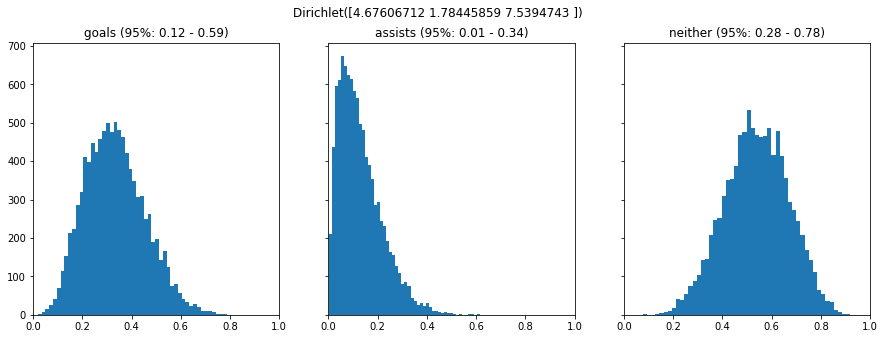

In [39]:
print("ADAM ARMSTRONG")
aa_id = get_player("Adam Armstrong").player_id
plot_dirichlet(model_fwd.posterior[model_fwd.player_ids == aa_id].reshape(3))

JAMIE VARDY


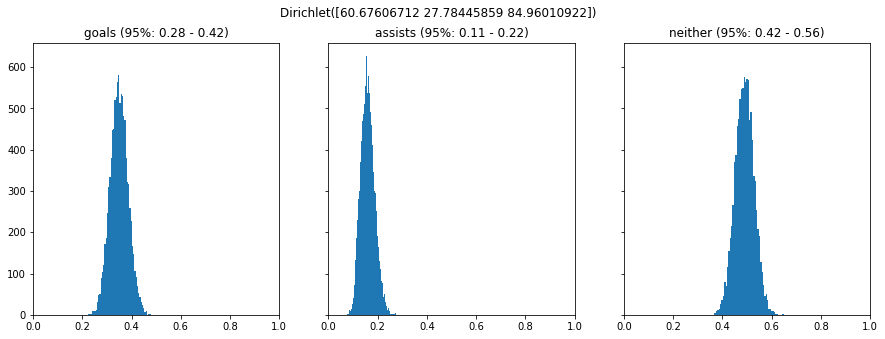

In [40]:
print("JAMIE VARDY")
jv_id = get_player("Jamie Vardy").player_id
plot_dirichlet(model_fwd.posterior[model_fwd.player_ids == jv_id].reshape(3))